In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import ast
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.preprocessing import LabelBinarizer
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import model_helper_functions
from sklearn.model_selection import GridSearchCV
import pickle
import os

In [2]:
DATA_PATH = r"C:\Users\SHUBHAM KUMAR SINGH\Desktop\data"
RANDOM_STATE = 42
pd.options.display.max_seq_items = 20
pd.options.display.max_rows = 50

In [34]:
SAVE_MODEL = True

MODEL_PATH = r"C:\Users\SHUBHAM KUMAR SINGH\Desktop\data"
MODEL_FILE_NAME = 'rf_tfidf_plus_guardian_model.sav'

In [4]:
df = pd.read_csv(r"C:\Users\SHUBHAM KUMAR SINGH\Desktop\data\datanews_dataset_pre_processed.csv", 
                 low_memory = False, 
                 usecols = ['title', 'text', 'label', 'clean_text_tokens', 'clean_title_tokens'])

In [6]:
df.clean_text_tokens = df.clean_text_tokens.map(ast.literal_eval)
df.clean_title_tokens = df.clean_title_tokens.map(ast.literal_eval)

In [7]:
df.head()

,title,text,label,clean_text_tokens,clean_title_tokens
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,fake,"[donald, trump, just, couldn, wish, all, ameri...","[donald, trump, sends, out, embarrassing, new,..."
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,fake,"[house, intelligence, committee, chairman, dev...","[drunk, bragging, trump, staffer, started, rus..."
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",fake,"[on, it, was, revealed, that, former, milwauke...","[sheriff, david, clarke, becomes, an, internet..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",fake,"[on, christmas, day, donald, trump, announced,...","[trump, is, so, obsessed, he, even, has, obama..."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,fake,"[pope, francis, used, his, annual, christmas, ...","[pope, francis, just, called, out, donald, tru..."


In [8]:
df_guard = pd.read_csv(r"C:\Users\SHUBHAM KUMAR SINGH\Desktop\data\dataguardian_news_dataset_cleaned.csv", 
                 low_memory = False)

In [9]:
df_guard.tt_tokens = df_guard.tt_tokens.map(ast.literal_eval)

In [10]:
df_fake = df[df.label == 'fake']

In [11]:
df_true_og = df[df.label == 'true']


In [12]:
len(df_fake)/2


8723.5

In [13]:
df_true_og_sample = df_true_og.sample(8724, random_state = RANDOM_STATE)


In [14]:
df_guard_sample = df_guard.sample(8723, random_state = RANDOM_STATE)


In [15]:
df_guard_sample['label'] = 'true'


In [16]:
df_true_og_sample['tt_tokens'] = df_true_og_sample['clean_title_tokens'] + df_true_og_sample['clean_text_tokens']


In [17]:
df_fake['tt_tokens'] = df_fake['clean_title_tokens'] + df_fake['clean_text_tokens']


C:\Users\SHUBHA~1\AppData\Local\Temp/ipykernel_18028/3469016795.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fake['tt_tokens'] = df_fake['clean_title_tokens'] + df_fake['clean_text_tokens']


In [18]:
df_all = pd.concat([df_fake[['label', 'tt_tokens']], 
                         df_true_og_sample[['label', 'tt_tokens']], 
                        df_guard_sample[['label', 'tt_tokens']]], axis=0)


In [19]:
y = df_all.label
X = df_all.drop('label', axis=1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                   test_size = 0.2,
                                                   random_state = RANDOM_STATE,
                                                   stratify = y)

In [21]:
X_train.shape


(27915, 1)

In [22]:
X_test.shape


(6979, 1)

In [23]:
le = LabelEncoder()


In [24]:
y_train_enc = le.fit_transform(y_train)


In [25]:
y_test_enc = le.transform(y_test)


In [26]:
def train_and_eval_model(X_train, X_test, y_train_enc, y_test_enc, classes_,
                        preprocessor, tokenizer, max_df=1.0, ngram_range = (1, 1),
                        min_samples_split=2,
                        max_depth=None):
    """
    Train and Evaluate and Bag of Words Representation with a Random Forest
    classifier.
    """
    
    pipeline = Pipeline([
    ('bow',CountVectorizer(min_df = 5, 
                           preprocessor = preprocessor, 
                           tokenizer = tokenizer, 
                           max_df = max_df, 
                           ngram_range = ngram_range)),
    ('tfidf', TfidfTransformer()),
    ('classifier', RandomForestClassifier(n_jobs = -1, 
                                          random_state = RANDOM_STATE, 
                                          min_samples_split = min_samples_split, 
                                          max_depth = max_depth)),
    ])
    
    pipeline.fit(X_train,y_train_enc)
    
    model_helper_functions.confustion_matrix_and_classification_report(pipeline, 
                                                X_train, 
                                                y_train_enc, 
                                                classes_, 
                                               'Training')

    model_helper_functions.confustion_matrix_and_classification_report(pipeline, 
                                                X_test, 
                                                y_test_enc, 
                                                classes_,
                                                'Test')
    
    return pipeline

In [27]:
gist_file = open(r"C:\Users\SHUBHAM KUMAR SINGH\Desktop\data\gist_stopwords.txt")
try:
    content = gist_file.read()
    expanded_stopwords = content.split(",")
finally:
    gist_file.close()

In [28]:
expanded_stopwords.remove('via')


In [29]:
expanded_stopwords.remove('eu')
expanded_stopwords.remove('uk')

In [30]:
def lowercase_and_only_expanded_stopwords(doc):
    """Remove stopwords and lowercase tokens"""
    stop_words = expanded_stopwords
    return [token.lower() for token in doc if token.lower() in stop_words]

Classification Report for Training Set
              precision    recall  f1-score   support

        fake       0.93      0.96      0.95     13957
        true       0.96      0.92      0.94     13958

    accuracy                           0.94     27915
   macro avg       0.94      0.94      0.94     27915
weighted avg       0.94      0.94      0.94     27915



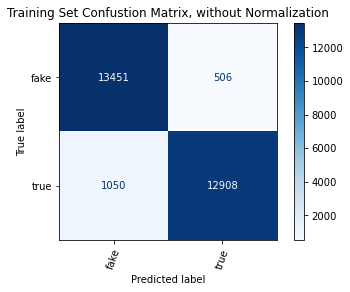

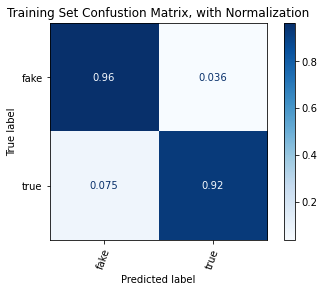

Classification Report for Test Set
              precision    recall  f1-score   support

        fake       0.88      0.91      0.89      3490
        true       0.90      0.88      0.89      3489

    accuracy                           0.89      6979
   macro avg       0.89      0.89      0.89      6979
weighted avg       0.89      0.89      0.89      6979



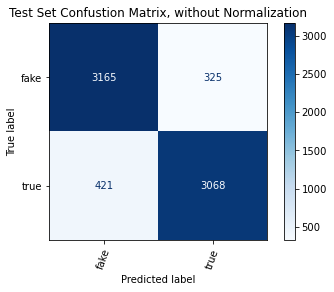

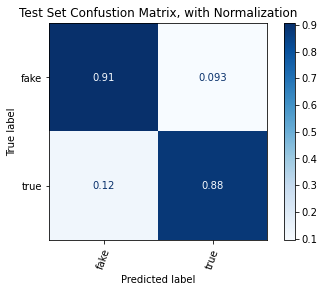

In [31]:
pipe_expanded_sw_no_via = train_and_eval_model(X_train['tt_tokens'], 
                                                        X_test['tt_tokens'],
                                                        y_train_enc, 
                                                        y_test_enc, 
                                                        le.classes_, 
                                                        lowercase_and_only_expanded_stopwords, 
                                                        model_helper_functions.passthrough,
                                                 min_samples_split = 0.005)

In [32]:
feat_imp_expanded_sw_no_via = pd.DataFrame(pipe_expanded_sw_no_via['classifier'].feature_importances_, 
                                       index = pipe_expanded_sw_no_via['bow'].get_feature_names(), 
                                       columns = ['importance']).sort_values('importance', 
                                                                             ascending=False)
feat_imp_expanded_sw_no_via.head(30)

,importance
said,0.134359
its,0.045391
the,0.040952
just,0.036174
you,0.032274
on,0.030297
this,0.026208
in,0.023002
like,0.021814
know,0.018277


In [33]:
try: 
    os.mkdir(MODEL_PATH)
except FileExistsError:
    print('Model directory already exists')
    pass

Model directory already exists


In [35]:
if SAVE_MODEL:
    pickle.dump(pipe_expanded_sw_no_via, open(MODEL_PATH + MODEL_FILE_NAME, 'wb'))